In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers import Input
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob

from tqdm import tqdm

import seaborn as sn
import pandas as pd

import pylab

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### I. **Preprocessing images**  
labels

resize

scale


In [ ]:
data = []
labels = []

dir_sample = "/content/drive/My Drive/projet_mercantour/sample/TVT1/"
videoList = os.listdir(dir_sample)

for path in videoList:

  firstdir = os.path.join(dir_sample,path)
  firstdirtList = os.listdir(firstdir)

  # r=root, d=directories, f = files 
  for r, d, f in os.walk(firstdir):
    for file in f:
      if file.endswith(".jpg"):
        
        imagePath = os.path.join(r, file)
        image = cv2.imread(imagePath)
        label = imagePath.split(os.path.sep)[-2]

        #resize picture
        image = cv2.resize(image,(224,224))#VGG16/19 (224x224x3RGB)

        data.append(image)
        labels.append(label)

#print(image)
#print(labels)

# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
#print(labels)

### II. **Training-Validation-Testing**

In [ ]:
# train 80% / validation 10% /test 10%
# X images and Y labels
# total =468

# Train + Validation (trainfull) 90% and Testing 10%
(trainfullX, testX, trainfullY, testY) = train_test_split(data, labels,test_size=0.1, random_state=42)
#print(len(trainfullY),len(testY)) #421/47
plt.figure(figsize=(15,5))
plt.hist(trainfullY,bins=15, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.show()

# Train 80% de 468 + Validation 10% de 468
(trainX,valX,trainY,valY) = train_test_split(trainfullX,trainfullY,test_size=0.11,random_state=42)
#print(len(trainY),len(valY)) #374/47

print(Counter(trainY))
print(Counter(valY))
print(Counter(testY))

#print(len(np.unique(trainfullY)))
#print(len(np.unique(trainY)))
#print(len(np.unique(valY)))
#print(len(np.unique(testY)))

# convert the labels from integers to vectors
le = LabelEncoder().fit(trainY)
trainY = np_utils.to_categorical(le.transform(trainY),15)
valY = np_utils.to_categorical(le.transform(valY),15)
testY = np_utils.to_categorical(le.transform(testY),15)

**show pictures**

In [ ]:
# show picture
plt.imshow(trainX[220])
plt.show()

In [ ]:
# show multiple pictures
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(trainX[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
plt.show()

## **III.VGG16**


###**A. Transfer learning**

In [ ]:
# load model without output layer
VGGmodel16 = VGG16(weights='imagenet',include_top=False, input_shape=(224, 224, 3))
VGGmodel16.summary()
#include_top = True : les dernières couches du CNN sont conservées. 

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# initialize the head model that will be placed on top of the base
headModel = VGGmodel16.output
headModel = Flatten()(headModel) 
# and add a fully-connected layer
headModel = Dense(1024, activation='relu')(headModel)
# finally, the softmax layer for predictions
headModel = Dense(len(np.unique(labels)), activation='softmax')(headModel)

# global network
model16 = Model(inputs=VGGmodel16.input, outputs=headModel)
model16.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
print(len(VGGmodel16.layers)) #19
print(len(model16.layers)) #22

19
22


In [ ]:
# train on last layers
for layer in model16.layers[:19]:
   layer.trainable = False
for layer in model16.layers[19:]:
   layer.trainable = True

# Compile the model
model16.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])

###**B.Training/ Validation model**

In [ ]:
# train the network
#print("[INFO] training network...")
#H = model16.fit(trainX, trainY, validation_data=(valX,valY),epochs=10)

In [ ]:
# we define a callback function that will control if the accuracy 
# on the validation set (a part of train set) is not changing more than 10-4 with a patience of 20 iterations
# If the last accuracy value is not the best one, we still keep the last results
ourCallback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

H2 = model16.fit(trainX, trainY, validation_data=(valX,valY),epochs=100, callbacks=[ourCallback])

Epoch 1/100
12/12 [==============================] - 195s 16s/step - loss: 1.1223 - accuracy: 0.6524 - val_loss: 0.4440 - val_accuracy: 0.8723
Epoch 2/100
12/12 [==============================] - 194s 16s/step - loss: 0.2213 - accuracy: 0.9198 - val_loss: 0.1419 - val_accuracy: 0.9574
Epoch 3/100
12/12 [==============================] - 194s 16s/step - loss: 0.1113 - accuracy: 0.9572 - val_loss: 0.0702 - val_accuracy: 0.9787
Epoch 4/100
12/12 [==============================] - 197s 16s/step - loss: 0.0572 - accuracy: 0.9840 - val_loss: 0.0503 - val_accuracy: 0.9787
Epoch 5/100
12/12 [==============================] - 196s 16s/step - loss: 0.0462 - accuracy: 0.9813 - val_loss: 0.0492 - val_accuracy: 0.9787
Epoch 6/100
12/12 [==============================] - 195s 16s/step - loss: 0.0389 - accuracy: 0.9813 - val_loss: 0.0228 - val_accuracy: 1.0000
Epoch 7/100
12/12 [==============================] - 193s 16s/step - loss: 0.0281 - accuracy: 1.0000 - val_loss: 0.0223 - val_accuracy: 1.0000

###**C. Evaluate model**

#### Loss function 

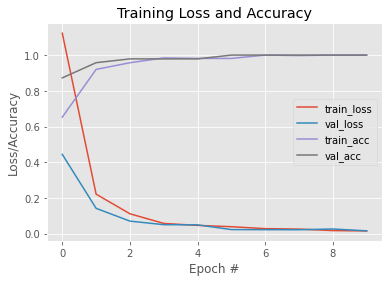

In [ ]:
# Loss function 

# plot the training + testing loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 10), H2.history["loss"], label="train_loss")
plt.plot(np.arange(0, 10), H2.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 10), H2.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 10), H2.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

#### Classification report

In [ ]:
names=le.classes_
namesvalY=np.delete(names,[7,12])

# evaluate the network
print("[INFO] evaluating network...")
pred = model16.predict(valX)
print(classification_report(valY.argmax(axis=1),pred.argmax(axis=1),target_names=namesvalY))

[INFO] evaluating network...
               precision    recall  f1-score   support

        biche       1.00      1.00      1.00         1
     blaireau       1.00      1.00      1.00         3
    bouquetin       1.00      1.00      1.00         2
         cerf       1.00      1.00      1.00         1
      chamois       1.00      1.00      1.00         4
    chevreuil       1.00      1.00      1.00        14
        chien       1.00      1.00      1.00         1
       humain       1.00      1.00      1.00         3
       lievre       1.00      1.00      1.00         2
lievre_europe       1.00      1.00      1.00         1
         loup       1.00      1.00      1.00         4
       renard       1.00      1.00      1.00         9
     sanglier       1.00      1.00      1.00         2

     accuracy                           1.00        47
    macro avg       1.00      1.00      1.00        47
 weighted avg       1.00      1.00      1.00        47



#### Confusion matrix

In [ ]:
CM = confusion_matrix(valY.argmax(axis=1),pred.argmax(axis=1))
print(CM)

[[ 1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 14  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  2]]


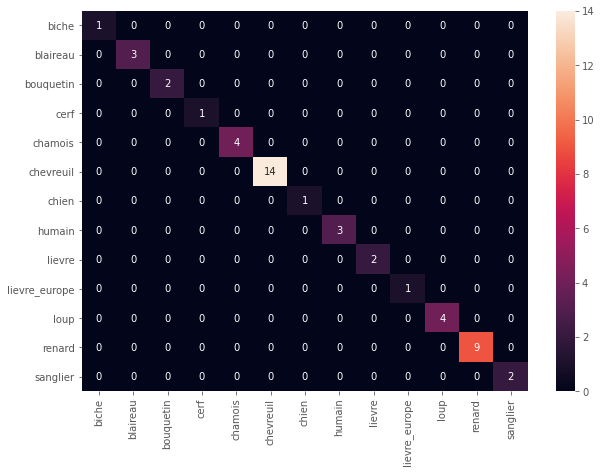

In [ ]:
#nicer display:
cm = pd.DataFrame(CM, index = [i for i in namesvalY],
                  columns = [i for i in namesvalY])
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)

#### Evaluate on test data

In [ ]:
score = model16.evaluate(testX,testY)
print("%s: %.2f%%" % (model16.metrics_names[1], score[1]*100))

2/2 [==============================] - 7s 4s/step - loss: 0.0174 - accuracy: 1.0000
accuracy: 100.00%


In [ ]:
predictions = model16.predict(testX)
predictions_prob = np.argmax(predictions, axis = 1)
predictions_names = names[predictions_prob]
print(predictions_names[:10])

['martre' 'bouquetin' 'biche' 'chevreuil' 'bouquetin' 'lievre' 'renard'
 'sanglier' 'humain' 'lievre']


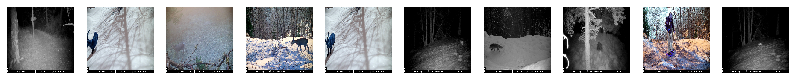

In [ ]:
# show multiple pictures
n_rows = 1
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(testX[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
plt.show()

# IV. VGG19

###**A. Transfer learning**

In [ ]:
# load model without output layer
VGGmodel19 = VGG19(weights='imagenet',include_top=False, input_shape=(224, 224, 3))
VGGmodel19.summary()
#include_top = True : les dernières couches du CNN sont conservées. 

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
# initialize the head model that will be placed on top of the base
headModel = VGGmodel19.output
headModel = Flatten()(headModel) 
# and add a fully-connected layer
headModel = Dense(1024, activation='relu')(headModel)
# finally, the softmax layer for predictions
headModel = Dense(len(np.unique(labels)), activation='softmax')(headModel)

# global network
model19 = Model(inputs=VGGmodel19.input, outputs=headModel)
model19.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
print(len(VGGmodel19.layers)) #22
print(len(model19.layers)) #25

22
25


In [ ]:
# train on last layers
for layer in model19.layers[:22]:
   layer.trainable = False
for layer in model19.layers[22:]:
   layer.trainable = True

# Compile the model
model19.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])

### **B.Training/Validation model**

In [ ]:
# train the network
#print("[INFO] training network...")
#H5 = model19.fit(trainX, trainY, validation_data=(valX,valY),epochs=10)

In [ ]:
# we define a callback function that will control if the accuracy 
# on the validation set (a part of train set) is not changing more than 10-4 with a patience of 20 iterations
# If the last accuracy value is not the best one, we still keep the last results
ourCallback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

H6 = model19.fit(trainX, trainY, validation_data=(valX,valY),epochs=100, callbacks=[ourCallback])

Epoch 1/100
12/12 [==============================] - 243s 20s/step - loss: 1.1492 - accuracy: 0.6631 - val_loss: 0.4769 - val_accuracy: 0.8298
Epoch 2/100
12/12 [==============================] - 241s 20s/step - loss: 0.2672 - accuracy: 0.9064 - val_loss: 0.1846 - val_accuracy: 0.9149
Epoch 3/100
12/12 [==============================] - 242s 20s/step - loss: 0.2345 - accuracy: 0.9225 - val_loss: 0.1394 - val_accuracy: 0.9787
Epoch 4/100
12/12 [==============================] - 241s 20s/step - loss: 0.1296 - accuracy: 0.9599 - val_loss: 0.3105 - val_accuracy: 0.9362
Epoch 5/100
12/12 [==============================] - 241s 20s/step - loss: 0.1120 - accuracy: 0.9572 - val_loss: 0.1519 - val_accuracy: 0.9574
Epoch 6/100
12/12 [==============================] - 241s 20s/step - loss: 0.0547 - accuracy: 0.9786 - val_loss: 0.0299 - val_accuracy: 1.0000
Epoch 7/100
12/12 [==============================] - 241s 20s/step - loss: 0.0606 - accuracy: 0.9759 - val_loss: 0.0706 - val_accuracy: 0.9787

###**C.Evaluate model**

#### Loss function

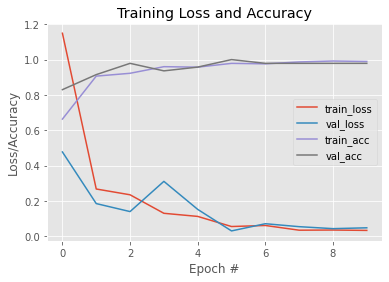

In [ ]:
# plot the training + testing loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 10), H6.history["loss"], label="train_loss")
plt.plot(np.arange(0, 10), H6.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 10), H6.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 10), H6.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

#### Classification report

In [ ]:
names=le.classes_
namesvalY=np.delete(names,[7,12])

# evaluate the network
print("[INFO] evaluating network...")
pred = model19.predict(valX)
print(classification_report(valY.argmax(axis=1),pred.argmax(axis=1),target_names=namesvalY))

[INFO] evaluating network...
               precision    recall  f1-score   support

        biche       1.00      1.00      1.00         1
     blaireau       1.00      1.00      1.00         3
    bouquetin       1.00      1.00      1.00         2
         cerf       1.00      1.00      1.00         1
      chamois       1.00      1.00      1.00         4
    chevreuil       1.00      1.00      1.00        14
        chien       1.00      1.00      1.00         1
       humain       1.00      1.00      1.00         3
       lievre       1.00      1.00      1.00         2
lievre_europe       0.00      0.00      0.00         1
         loup       0.80      1.00      0.89         4
       renard       1.00      1.00      1.00         9
     sanglier       1.00      1.00      1.00         2

     accuracy                           0.98        47
    macro avg       0.91      0.92      0.91        47
 weighted avg       0.96      0.98      0.97        47



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Confusion matrix

In [ ]:
CM = confusion_matrix(valY.argmax(axis=1),pred.argmax(axis=1))
print(CM)

[[ 1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 14  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  2]]


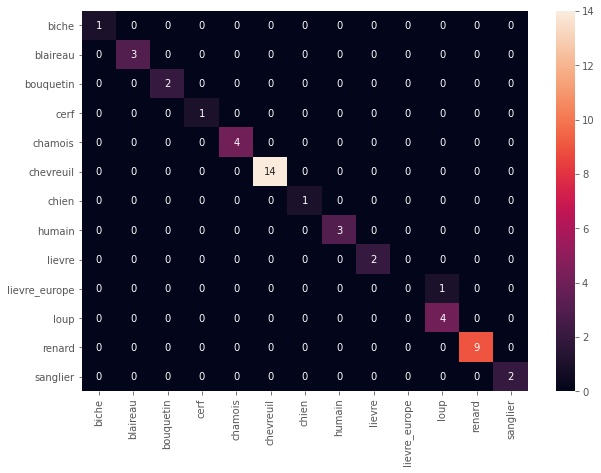

In [ ]:
#nicer display:
cm = pd.DataFrame(CM, index = [i for i in namesvalY],
                  columns = [i for i in namesvalY])
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)

#### Evaluate on test data

In [ ]:
score = model19.evaluate(testX,testY)
print("%s: %.2f%%" % (model19.metrics_names[1], score[1]*100))

2/2 [==============================] - 10s 5s/step - loss: 0.0349 - accuracy: 0.9787
accuracy: 97.87%


# V. Repeat VGG16 X20

In [ ]:
my_dict = {}
score_eval = {}

for i in range(1,21):
  
   # TRAINING/ VALIDATION/ TESTING

  # train 80% / validation 10% /test 10%
  # X images and Y labels
  # total =468

  # Train + Validation (trainfull) 90% and Testing 10%
  (trainfullX, testX, trainfullY, testY) = train_test_split(data, labels,test_size=0.1)

  # Train 80% de 468 + Validation 10% de 468
  (trainX,valX,trainY,valY) = train_test_split(trainfullX,trainfullY,test_size=0.11)

  # convert the labels from integers to vectors
  le = LabelEncoder().fit(trainY)
  trainY = np_utils.to_categorical(le.transform(trainY),15)
  valY = np_utils.to_categorical(le.transform(valY),15)
  testY = np_utils.to_categorical(le.transform(testY),15)

  # RUN MODEL

  # load model without output layer
  VGGmodel16 = VGG16(weights='imagenet',include_top=False, input_shape=(224, 224, 3))
  #include_top = True : les dernières couches du CNN sont conservées. 

  # initialize the head model that will be placed on top of the base
  headModel = VGGmodel16.output
  headModel = Flatten()(headModel) 
  # and add a fully-connected layer
  headModel = Dense(1024, activation='relu')(headModel)
  # finally, the softmax layer for predictions
  headModel = Dense(len(np.unique(labels)), activation='softmax')(headModel)

  # global network
  model16 = Model(inputs=VGGmodel16.input, outputs=headModel)

  # train on last layers
  for layer in model16.layers[:19]:
    layer.trainable = False
  for layer in model16.layers[19:]:
    layer.trainable = True

  # Compile the model
  model16.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])

  # we define a callback function that will control if the accuracy 
  # on the validation set (a part of train set) is not changing more than 10-4 with a patience of 20 iterations
  # If the last accuracy value is not the best one, we still keep the last results
  ourCallback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

  H = model16.fit(trainX, trainY, validation_data=(valX,valY),epochs=100, callbacks=[ourCallback])
  
  my_dict["H"+str(i)] = H

  score = model16.evaluate(testX,testY)

  score_eval["score"+str(i)] = score

58892288/58889256 [==============================] - 1s 0us/step
Epoch 1/100
12/12 [==============================] - 7s 586ms/step - loss: 1.0090 - accuracy: 0.7246 - val_loss: 0.3045 - val_accuracy: 0.9362
Epoch 2/100
12/12 [==============================] - 3s 245ms/step - loss: 0.2148 - accuracy: 0.9225 - val_loss: 0.1201 - val_accuracy: 0.9362
Epoch 3/100
12/12 [==============================] - 3s 244ms/step - loss: 0.1392 - accuracy: 0.9439 - val_loss: 0.0778 - val_accuracy: 0.9574
Epoch 4/100
12/12 [==============================] - 3s 246ms/step - loss: 0.0668 - accuracy: 0.9706 - val_loss: 0.1065 - val_accuracy: 0.9362
Epoch 5/100
12/12 [==============================] - 3s 246ms/step - loss: 0.0346 - accuracy: 0.9947 - val_loss: 0.0398 - val_accuracy: 1.0000
Epoch 6/100
12/12 [==============================] - 3s 245ms/step - loss: 0.0240 - accuracy: 1.0000 - val_loss: 0.0455 - val_accuracy: 0.9787
Epoch 7/100
12/12 [==============================] - 3s 245ms/step - loss: 0.

In [ ]:
loss = []
accuracy = []
val_loss = []
val_accuracy = []
score1 = []

for i in range(1,21):

  my_key = i

  loss0=  my_dict["H"+str(i)].history["loss"][-1]
  loss.append(loss0)

  accuracy0=  my_dict["H"+str(i)].history["accuracy"][-1]
  accuracy.append(accuracy0)

  val_loss0=  my_dict["H"+str(i)].history["val_loss"][-1]
  val_loss.append(val_loss0)
  
  val_accuracy0=  my_dict["H"+str(i)].history["val_accuracy"][-1]
  val_accuracy.append(val_accuracy0)

  score0=  score_eval["score"+str(i)][1]*100
  score1.append(score0)
  
  #print(my_dict["H"+str(i)].history["loss"][-1])
  #print(my_dict["H"+str(i)].history["accuracy"][-1])
  #print(my_dict["H"+str(i)].history["val_loss"][-1])
  #print(my_dict["H"+str(i)].history["val_accuracy"][-1])
  #print(score_eval["score"+str(i)][1]*100)

print(loss)
print(accuracy)
print(val_loss)
print(val_accuracy)
print(score1)

[0.01366091426461935, 0.022576097398996353, 0.029316669330000877, 0.018876655027270317, 0.053623016923666, 0.023860080167651176, 0.03798238933086395, 0.029777303338050842, 0.039265867322683334, 0.019689613953232765, 0.018555279821157455, 0.03080148994922638, 0.014490501023828983, 0.019335255026817322, 0.031342439353466034, 0.015077034942805767, 0.019453592598438263, 0.05760549008846283, 0.014719666913151741, 0.016056464985013008]
[1.0, 0.9919785857200623, 0.9919785857200623, 1.0, 0.9759358167648315, 0.9973261952400208, 0.9973261952400208, 1.0, 0.98128342628479, 0.9973261952400208, 0.9946523904800415, 0.9946523904800415, 1.0, 1.0, 0.9919785857200623, 1.0, 1.0, 0.970588207244873, 1.0, 1.0]
[0.03630268946290016, 0.02990351803600788, 0.028713421896100044, 0.029596103355288506, 0.07567716389894485, 0.0457565113902092, 0.012568119913339615, 0.030918337404727936, 0.020162247121334076, 0.03897269442677498, 0.014994337223470211, 0.03594718873500824, 0.043020155280828476, 0.10538993030786514, 0.

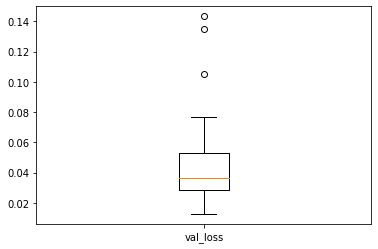

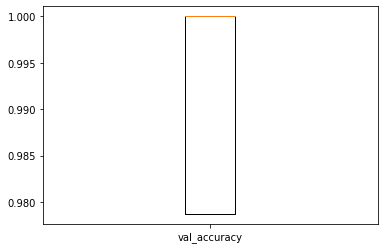

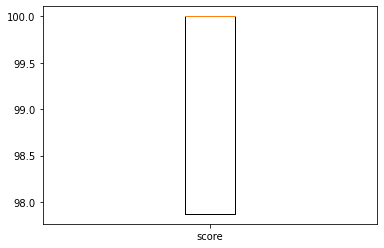

In [ ]:
# box plot "Loss"

BoxName1 = ['val_loss']
databoxplot1 = [val_loss]
plt.boxplot(databoxplot1)
pylab.xticks([1], BoxName1)
plt.show()

# box plot "accuracy"

BoxName2 = ['val_accuracy']
databoxplot2 = [val_accuracy]
plt.boxplot(databoxplot2)
pylab.xticks([1], BoxName2)
plt.show()

# box plot "score"

BoxName3 = ['score']
databoxplot3 = [score1]
plt.boxplot(databoxplot3)
pylab.xticks([1], BoxName3)
plt.show()

#package seaborn pour plus jolie
#https://cmdlinetips.com/2018/03/how-to-make-boxplots-in-python-with-pandas-and-seaborn/

à regarder

In [ ]:
add a dense layer
modify the number of neurons in dense layer(s)
change the global average polling
experiment other optimizers (SGD, Adam, ...)